In [35]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy import units as u 
import datetime
import numpy as np 
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import hist
sns.set_context("paper", font_scale=1.3)

import warnings
warnings.filterwarnings("ignore")

## Read in flare list 

In [86]:
flare_list = pd.read_csv("flare_list_all_times_calc.csv")
flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])
flare_list["event_endtime"] = pd.to_datetime(flare_list["event_endtime"])
flare_list["full_dur"] = [x.total_seconds() for x in (flare_list["event_endtime"]-flare_list["event_starttime"])]

In [87]:
hpc_coords = SkyCoord(flare_list["hpc_x"]*u.arcsec, flare_list["hpc_y"]*u.arcsec, 
                      frame=frames.Helioprojective, obstime=flare_list["event_starttime"], 
                      observer="earth")

hcr_coords = hpc_coords.transform_to(frames.Heliocentric)
phi = hcr_coords.cylindrical.phi.wrap_at(360*u.deg).value

flare_list["phi"] = phi-90


flare_list.loc[(flare_list.phi < 0),'phi']=flare_list.phi+360

In [88]:
flare_list["goes_class_ind"].value_counts()

C    7800
M     748
X      49
Name: goes_class_ind, dtype: int64

# Some initial plots

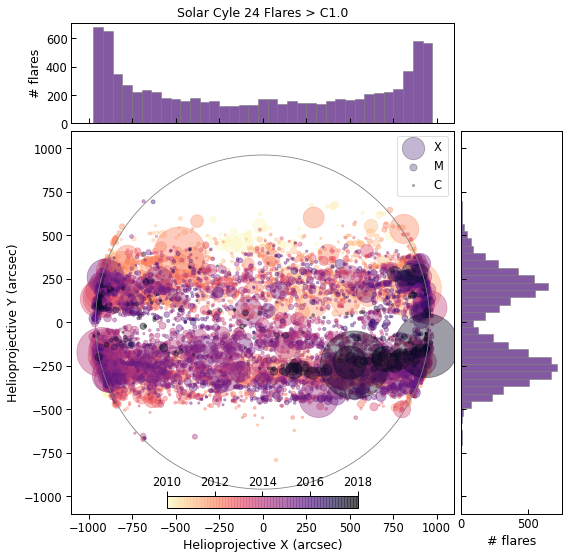

In [89]:

flares_p = flare_list[flare_list["hgs_lat"]>-60]
fig, ax = plt.subplots(figsize=(8, 8))

cmap = matplotlib.cm.get_cmap('magma_r')
cc = cmap(0.75)


axins1 = inset_axes(ax, 
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

# the scatter plot:
im = ax.scatter(flares_p["hpc_x"], flares_p["hpc_y"], alpha=0.4, s=5*flares_p["goes_class_val"]*1e6,
            c=flares_p["tt"]/60/60/60/60, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
# Set aspect of the main axes.
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.4, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.4, pad=0.1, sharey=ax)

ax_histx.tick_params(labelbottom=False, direction="in")
ax_histy.tick_params(labelleft=False, direction="in")
# ax.tick_params(direction="in", right="in", top="in")

_ = ax_histx.hist(flares_p["hpc_x"], bins=35, color=cc, alpha=0.7,  edgecolor="grey")
_ = ax_histy.hist(flares_p["hpc_y"], bins=35, orientation='horizontal', color=cc, alpha=0.7, edgecolor="grey")

ax.set_xlabel("Helioprojective X (arcsec)")
ax.set_ylabel("Helioprojective Y (arcsec)")
ax_histx.set_ylabel("# flares")
ax_histy.set_xlabel("# flares")

ax_histx.set_title("Solar Cyle 24 Flares > C1.0")

cbar = fig.colorbar(im, cax=axins1, orientation="horizontal", ticks=[0, 5, 10, 15, 20])
axins1.set_xticklabels(['2010', '2012', '2014', '2016', '2018'], rotation=0) 
axins1.xaxis.tick_top()


ax.scatter(np.nan, np.nan, s=5*1e6*(1e-4), color=cmap(0.8), alpha=0.3, edgecolor="k", label="X")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-5), color=cmap(0.8), alpha=0.3, edgecolor="k", label="M")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-6), color=cmap(0.8), alpha=0.3, edgecolor="k", label="C")
ax.legend()
plt.tight_layout()

Text(0, 0.5, 'Integrated flux')

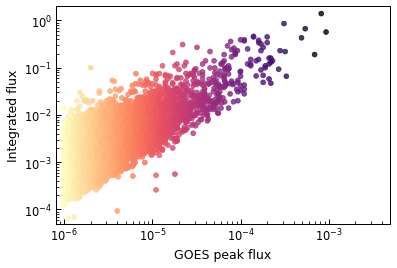

In [90]:
plt.scatter(flare_list["goes_class_val"], flare_list["integrated_flux"], 
            c=flare_list["goes_class_val"], alpha=0.8, norm=LogNorm(), cmap="magma_r")
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlim(8e-7, 5e-3)
plt.ylim(5e-5, 2)

plt.xlabel("GOES peak flux")
plt.ylabel("Integrated flux")

In [91]:
flare_list2 = flare_list[~flare_list["fwhm_dur"].isnull()]

Text(0.5, 0, 'FWHM duration (s)')

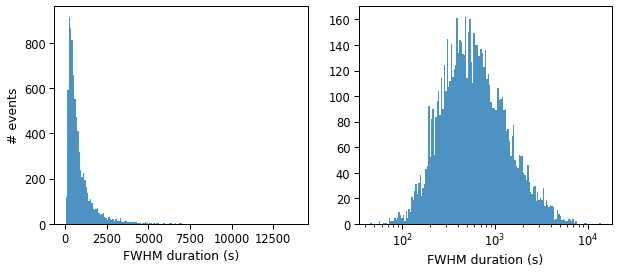

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

n, linear_bins, _ = hist(flare_list2["fwhm_dur"], alpha=0.8,  linewidth=0.5, 
                         bins="knuth", align='mid', ax=ax[0])
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

_ = hist(flare_list2["fwhm_dur"], alpha=0.8, linewidth=0.5,
         bins=logbins, ax=ax[1])
ax[1].set_xscale("log")

ax[0].set_ylabel("# events")
ax[0].set_xlabel("FWHM duration (s)")
ax[1].set_xlabel("FWHM duration (s)")

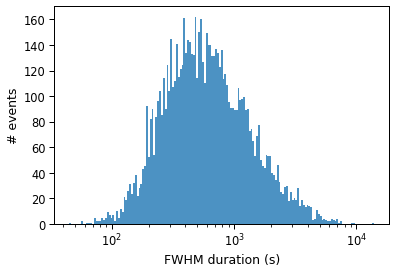

In [245]:
fig, ax = plt.subplots()

n, linear_bins, _ = hist(flare_list2["fwhm_dur"], alpha=0.8,  linewidth=0.5, 
                         bins="knuth", align='mid')
plt.close()
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

_ = hist(flare_list2["fwhm_dur"], alpha=0.8, linewidth=0.5,
         bins=logbins)
ax = plt.gca()
ax.set_xscale("log")

ax.set_ylabel("# events")
ax.set_xlabel("FWHM duration (s)")

plt.savefig("duration_dist.png", dpi=200, facecolor="w")

SpearmanrResult(correlation=0.20259515266562086, pvalue=2.5426395688278574e-80)


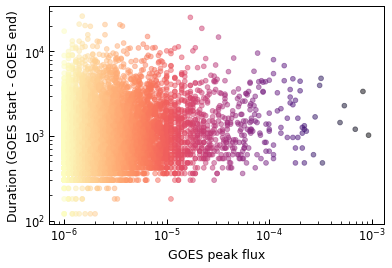

In [134]:
plt.scatter(flare_list["goes_class_val"], flare_list["full_dur"], alpha=0.9, 
         c=flare_list["goes_class_val"], norm=LogNorm(), cmap="magma_r")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Duration (GOES start - GOES end)")
plt.xlabel("GOES peak flux")
plt.tick_params(which="both", direction="in")
print(scipy.stats.spearmanr(flare_list["goes_class_val"], flare_list["full_dur"]))

SpearmanrResult(correlation=0.12794585500801184, pvalue=9.144304932145375e-31)


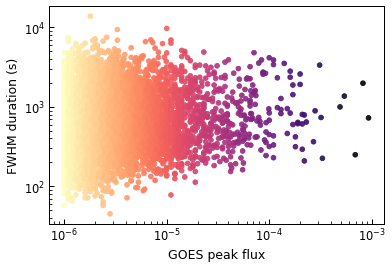

In [241]:
plt.scatter(flare_list2["goes_class_val"], flare_list2["fwhm_dur"], alpha=0.9, c=flare_list2["goes_class_val"], 
            norm=LogNorm(), cmap="magma_r")
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("GOES peak flux")
plt.ylabel("FWHM duration (s)")
print(scipy.stats.spearmanr(flare_list2["goes_class_val"], flare_list2["fwhm_dur"]))

plt.savefig("flare_duration_fwhm_goesflux.png", dpi=200, facecolor="w")

# AR analysis

Lets first inspect data that has no AR informtion

In [141]:
print("Around {:.2f}% flares have no AR data".format(100*np.sum(flare_list["noaa_ar"].isin([0]))/len(flare_list)))

Around 10.89% flares have no AR data


In [142]:
flares_no_ar = flare_list[flare_list["noaa_ar"].isin([0])]
flares_no_ar["goes_class_ind"].value_counts()

C    912
M     24
Name: goes_class_ind, dtype: int64

(-1100.0, 1100.0)

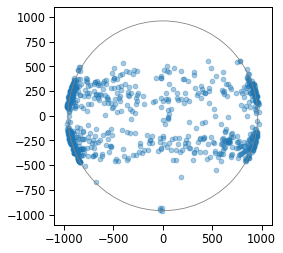

In [143]:
fig, ax = plt.subplots()
cmap="viridis"

im = ax.scatter(flares_no_ar["hpc_x"], flares_no_ar["hpc_y"], alpha=0.4, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)

Text(0.5, 1.0, 'Flares with no AR association')

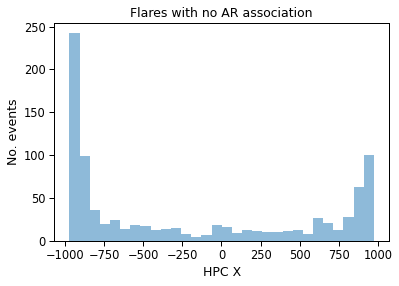

In [144]:
_ = plt.hist(flares_no_ar["hpc_x"], bins=30, alpha=0.5)
plt.ylabel("No. events")
plt.xlabel("HPC X")
plt.title("Flares with no AR association")

Ok that makes sense, those flares that occur on limb comming onto disk have not yet been assigned AR

# Read in AR info

In [145]:
ar_data = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/AR_analysis/SRS_all_2010-2018.csv")
ar_data = ar_data[ar_data["ID"].isin(["I"])]
ar_data["matchtime"] = ar_data["date"]
ar_data["noaa_ar"] = ar_data["Number"]

In [146]:
ar_data.keys()

Index(['ID', 'Number', 'Carrington Longitude', 'Area', 'Z',
       'Longitudinal Extent', 'Number of Sunspots', 'Mag Type', 'Latitude',
       'Longitude', 'date', 'matchtime', 'noaa_ar'],
      dtype='object')

In [147]:
flare_ar_df = pd.merge(flare_list, ar_data, how="left", on=["matchtime", "noaa_ar"])

In [148]:
len(flare_ar_df)

8597

In [308]:
flare_ar = flare_ar_df[flare_ar_df["noaa_ar"]!=0]

flare_x = flare_ar[flare_ar["goes_class_ind"].isin(["X"])].dropna()
flare_m = flare_ar[flare_ar["goes_class_ind"].isin(["M", "X"])].dropna()

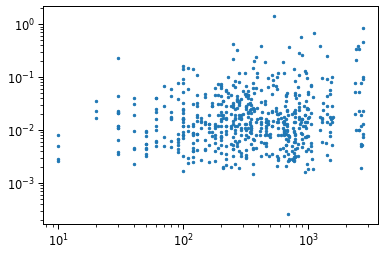

In [309]:
plt.plot(flare_m.Area, flare_m.integrated_flux, marker='.', ls='')
plt.xscale("log")
plt.yscale("log")

In [314]:
scipy.stats.spearmanr(flare_m["goes_class_val"], flare_m["Number of Sunspots"])

SpearmanrResult(correlation=0.008666437292555803, pvalue=0.83126292096374)

SpearmanrResult(correlation=0.0058181230239209205, pvalue=0.9723448916162365)


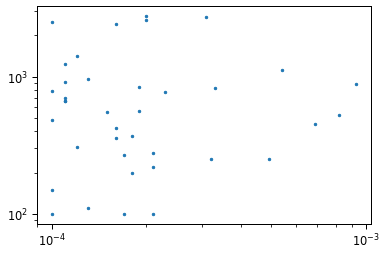

In [167]:
plt.plot(flare_x["goes_class_val"], flare_x["Area"], marker='.', ls='')
plt.xscale("log")
plt.yscale("log")

print(scipy.stats.spearmanr(flare_x["goes_class_val"], flare_x["Area"]))

In [168]:
unique_ar = flare_ar["noaa_ar"].unique()
events = []
for ar in unique_ar:
    unique_df = flare_ar_df[flare_ar_df.noaa_ar.isin([ar])]
    event = {}
    event["ar_num"] = ar
    event["number_flares"] = len(unique_df)
    event["c_flares"] = np.sum(unique_df["goes_class_ind"].isin(["C"]))
    event["m_flares"] = np.sum(unique_df["goes_class_ind"].isin(["M"]))
    event["x_flares"] = np.sum(unique_df["goes_class_ind"].isin(["X"]))
    event["max_flare"] = np.max(unique_df["goes_class_val"])
    event["max_area"] = np.max(unique_df["Area"])
    event["max_sunspots"] = np.max(unique_df["Number of Sunspots"])    
    event["ar_class_max"] = unique_df.iloc[np.argmax(unique_df["goes_class_val"])]["Mag Type"]
    events.append(event)

events = pd.DataFrame(events)

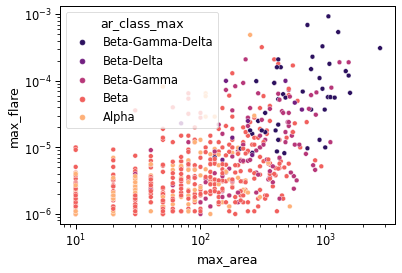

In [169]:
events = events[events.max_area>0]

order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
sns.scatterplot(data=events, x="max_area", y="max_flare", hue="ar_class_max", palette="magma", hue_order=order[::-1])
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, 'Max X-ray flux (Wm$^{-2}$)')

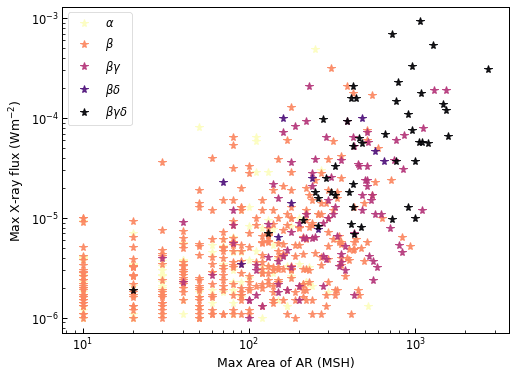

In [172]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0,1,len(order)))
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(order)):
    aa = events[events["ar_class_max"].isin([order[i]])]
    plt.plot(aa["max_area"], aa["max_flare"], marker="*", ms=8, ls='', color=colors[i], alpha=0.9, 
             label=labels[i])

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("Max Area of AR (MSH)")
plt.ylabel("Max X-ray flux (Wm$^{-2}$)")

In [352]:
flare_ar["unique_day"] = flare_ar["event_starttime"].dt.strftime("%Y-%m-%d")
flare_ar["unique_month"] = flare_ar["event_starttime"].dt.strftime("%Y-%m")

<AxesSubplot:xlabel='unique_month'>

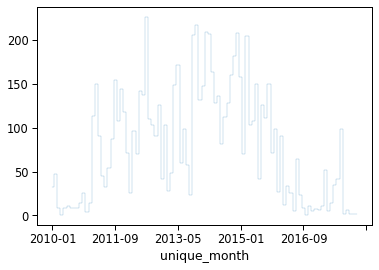

In [354]:
flare_ar.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", lw=0.2)

In [401]:
def plot_area_disk(flare_ar, average="unique_day", log=True, plot=True):
    total_area = flare_ar.groupby(average)["Area"].sum()
    total_flares = flare_ar.groupby(average)["goes_class_ind"].count()
    if plot:
        plt.plot(total_area, total_flares, marker='.', ls='')
        if log:
            plt.yscale("log")
            plt.xscale("log")
        plt.xlabel("Total disk AR area")
        plt.ylabel("#No flares")
        plt.title("{:s} averaged solar cycle 24".format(average))
    print(scipy.stats.spearmanr(total_area, total_flares))
    return total_area, total_flares

SpearmanrResult(correlation=0.6817396969510591, pvalue=2.5574035200228507e-224)
SpearmanrResult(correlation=0.5383992212803306, pvalue=1.1459774243071812e-31)
SpearmanrResult(correlation=-0.12422884798392574, pvalue=0.4217218825205916)


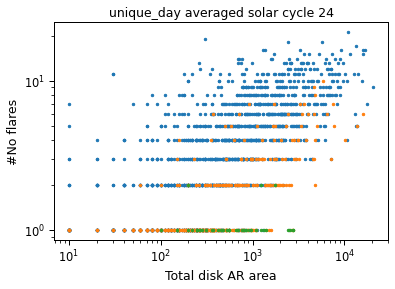

In [414]:
# total_area, total_flares = plot_area_disk(flare_ar)
flare_x = flare_ar[flare_ar["goes_class_ind"].isin(["X"])]
flare_m = flare_ar[flare_ar["goes_class_ind"].isin(["M"])]
flare_c = flare_ar[flare_ar["goes_class_ind"].isin(["C"])]


scaling_c = len(flare_c)/len(flare_ar)
scaling_m = len(flare_m)/len(flare_ar)
scaling_x = len(flare_x)/len(flare_ar)

total_area_c, total_flares_c = plot_area_disk(flare_c)
total_area_m, total_flares_m = plot_area_disk(flare_m)
total_area_x, total_flares_x = plot_area_disk(flare_x)

SpearmanrResult(correlation=0.7022981588171302, pvalue=2.135989774996035e-246)


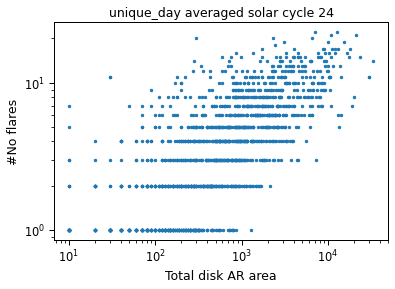

In [415]:
_ = plot_area_disk(flare_ar)

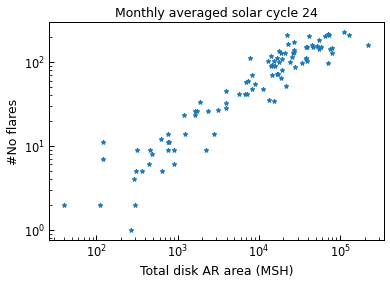

In [417]:
total_area = flare_ar.groupby("unique_month")["Area"].sum()
total_flares = flare_ar.groupby("unique_month")["goes_class_ind"].count()

plt.plot(total_area, total_flares, marker='*', ls='')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Total disk AR area (MSH)")
plt.ylabel("#No flares")
plt.title("Monthly averaged solar cycle 24")
plt.tick_params(which="both", direction="in")

# Lets look at flaring rates per active region area

In [343]:
def bound_ar_area(x):
    if x <= 100:
        return "small"
    elif x>100 and x<=500:
        return "small-medium"
    elif x>500 and x<1000:
        return "medium"
    elif x>1000:
        return "large"
    else:
        return np.nan
    

In [344]:
flare_ar["ar_area"] = flare_ar["Area"].map(bound_ar_area)

In [345]:
flare_ar.groupby(["Area", "goes_class_ind"])["noaa_ar"].count().unstack()

goes_class_ind,C,M,X
Area,,,
0.0,10.0,NaN,NaN
10.0,229.0,6.0,NaN
20.0,215.0,4.0,NaN
25.0,1.0,NaN,NaN
30.0,256.0,13.0,NaN
...,...,...,...
2570.0,8.0,4.0,1.0
2680.0,5.0,6.0,NaN
2700.0,4.0,1.0,NaN


In [348]:
flare_ar["ar_area"].value_counts()

small-medium    3243
small           1888
medium          1072
large            327
Name: ar_area, dtype: int64

In [328]:
np.sort(flare_ar["Area"].unique())

array([   0.,   10.,   20.,   25.,   30.,   40.,   50.,   60.,   70.,
         80.,   90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,
        165.,  170.,  180.,  190.,  200.,  205.,  210.,  220.,  230.,
        240.,  250.,  260.,  270.,  280.,  290.,  300.,  310.,  320.,
        330.,  340.,  350.,  360.,  370.,  380.,  390.,  400.,  410.,
        420.,  430.,  440.,  450.,  460.,  470.,  480.,  490.,  500.,
        510.,  520.,  530.,  540.,  550.,  560.,  570.,  580.,  590.,
        600.,  610.,  620.,  630.,  640.,  650.,  660.,  670.,  680.,
        690.,  700.,  710.,  720.,  730.,  740.,  750.,  760.,  770.,
        780.,  790.,  800.,  810.,  820.,  830.,  840.,  850.,  860.,
        880.,  890.,  900.,  910.,  920.,  930.,  940.,  950.,  960.,
        970.,  980.,  990., 1000., 1020., 1030., 1040., 1050., 1060.,
       1070., 1080., 1090., 1100., 1120., 1190., 1230., 1240., 1250.,
       1260., 1270., 1280., 1300., 1320., 1370., 1400., 1410., 1415.,
       1420., 1460.,

# Get CME data

In [226]:
cme_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/cme_lists/final_cme_list_2010_2018.csv")
cme_list["start_time_c2"] = pd.to_datetime(cme_list.date + cme_list.time, format="%Y/%m/%d%H:%M:%S") 

def get_times(x):
    xx = x.split()
    if len(xx)==3:
        return pd.to_datetime(" ".join(xx[1:]))
    else:
        return np.nan

cme_list["onset_times1"] = cme_list.onset_times1.map(get_times)
cme_list["onset_times2"] = cme_list.onset_times2.map(get_times)

In [227]:
len(cme_list)

14764

In [228]:
cme_list.head(3)

,date,time,central_pa,width,linear_speed,2nd_order_speed_inital,2nd_order_speed_final,2nd_order_speed_20R,accel,mass,kinetic_energy,MPA,remarks,time_c2,onset_times1,onset_times2,onset_times2_rsun,quality_index,quality_val,start_time_c2
0,2010/01/01,06:54:03,354,6,330,269,396,959,35.5*,-------,-------,355,Very Poor Event; Only 3 points; Only C2,2010-01-01 06:54:03,2010-01-01 05:50:03,2010-01-01 04:48:01,#ONSET2_RSUN: 1.38,#QUALITY_INDEX: 0 (Ill-Defined),0,2010-01-01 06:54:03
1,2010/01/01,08:30:03,248,75,148,60,244,220,1.9*,4.2e+14,4.6e+28,253,Poor Event,2010-01-01 08:30:03,2010-01-01 07:11:32,2009-12-31 23:10:35,#ONSET2_RSUN: 1.98,#QUALITY_INDEX: 1 (Poor),1,2010-01-01 08:30:03
2,2010/01/01,17:06:03,49,21,729,764,694,700,-3.9,4.0e+14,1.1e+30,52,NaN,2010-01-01 17:06:03,2010-01-01 16:45:44,2010-01-01 16:48:50,#ONSET2_RSUN: 1.00,#QUALITY_INDEX: 3 (Typical),3,2010-01-01 17:06:03


In [229]:
def find_cme(flare_list, i):
    """
    Function to find is there is an associated CME for a particular flare
    
    Parameters
    ----------
    flare_list : pd.DataFrame
        flare list to search from
    i : ~int
        index of flare_list row to search for
        
    Returns
    -------
    yes/no : `str` 
        if there is an associated eruption
    positional angle difference : `float`
        absolute value of difference in angle between flare/CME
    quality : `int`
        quality index of eruptive event
    """
    
    
    # check its within 3 hours of flare
    cme_list_compare = cme_list[(cme_list["start_time_c2"]>=flare_list.iloc[i]["event_starttime"]\
                                 -datetime.timedelta(minutes=5)) &
                                (cme_list["start_time_c2"]<=flare_list.iloc[i]["event_starttime"]\
                                 +datetime.timedelta(hours=2))]
    
    # make sure the position locations make sense - absolute value <45 degrees between two
    cme_list_compare = cme_list_compare[np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi)<=90]
    
    # checks outputs and returns values if CMEs available
    if len(cme_list_compare)==0:
        return "no", np.nan, 0
    
    elif len(cme_list_compare)==1:
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]
    
    else:
#         print("more that one! {:d} has {:d} CMEs".format(i, len(cme_list_compare)))
#         print(cme_list_compare.quality_val.values, np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values)
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]


In [256]:
flare_interest = flare_list[flare_list["goes_class_val"]>=5e-6]

In [257]:
flare_interest["goes_class_ind"].value_counts()

C    979
M    748
X     49
Name: goes_class_ind, dtype: int64

In [258]:
find_cme(flare_interest, 0)

('no', nan, 0)

In [259]:
cmes = []; angle_list = []; qual = []
for i in range(len(flare_interest)):
    cme, ang, q = find_cme(flare_interest, i)
    cmes.append(cme)
    angle_list.append(ang)
    qual.append(q)
    
flare_interest["cmes"] = cmes
flare_interest["angles"] = angle_list
flare_interest["qual"] = qual

In [260]:
flare_x = flare_interest[flare_interest["goes_class_ind"].isin(["X"])]
flare_m = flare_interest[flare_interest["goes_class_ind"].isin(["M"])]
flare_c = flare_interest[flare_interest["goes_class_ind"].isin(["C"])]

print("X \n",100*flare_x["cmes"].value_counts()/len(flare_x))
print("M \n",100*flare_m["cmes"].value_counts()/len(flare_m))
print("C \n",100*flare_c["cmes"].value_counts()/len(flare_c))

X 
 yes    83.673469
no     16.326531
Name: cmes, dtype: float64
M 
 no     50.534759
yes    49.465241
Name: cmes, dtype: float64
C 
 no     62.512768
yes    37.487232
Name: cmes, dtype: float64


In [294]:
flare_cmes = flare_interest[(flare_interest.qual>3)]
flare_nocmes = flare_interest[(flare_interest.qual<=3)]

In [295]:
print(len(flare_cmes))
print(len(flare_nocmes))

155
1621


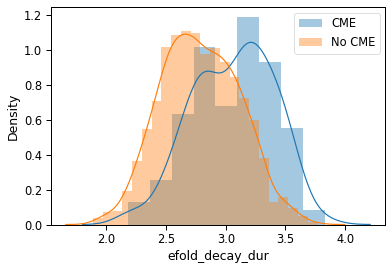

In [296]:
sns.distplot(np.log10(flare_cmes["efold_decay_dur"]), label="CME")
sns.distplot(np.log10(flare_nocmes["efold_decay_dur"]), label="No CME")
plt.legend()

<AxesSubplot:xlabel='fwhm_dur', ylabel='Density'>

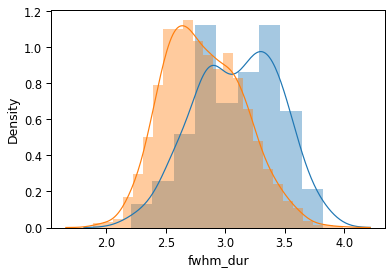

In [297]:
sns.distplot(np.log10(flare_cmes["fwhm_dur"]))
sns.distplot(np.log10(flare_nocmes["fwhm_dur"]))

<AxesSubplot:xlabel='efold_decay_dur', ylabel='Density'>

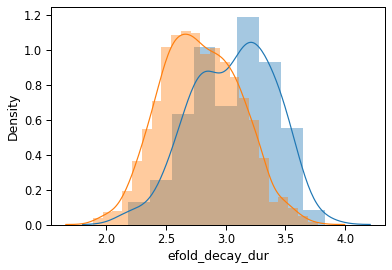

In [298]:
sns.distplot(np.log10(flare_cmes["efold_decay_dur"]))
sns.distplot(np.log10(flare_nocmes["efold_decay_dur"]))

<AxesSubplot:xlabel='fwhm_rise', ylabel='Density'>

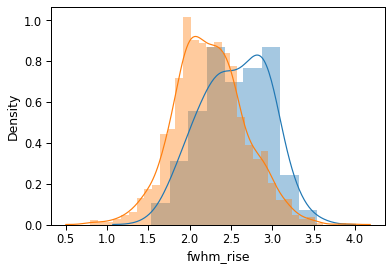

In [299]:
sns.distplot(np.log10(flare_cmes["fwhm_rise"]))
sns.distplot(np.log10(flare_nocmes["fwhm_rise"]))

<AxesSubplot:xlabel='fwhm_decay', ylabel='Density'>

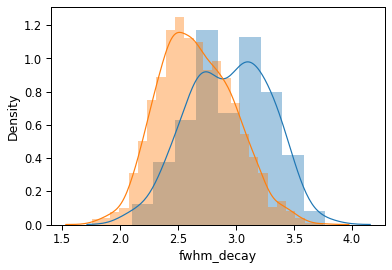

In [300]:
sns.distplot(np.log10(flare_cmes["fwhm_decay"]))
sns.distplot(np.log10(flare_nocmes["fwhm_decay"]))

Text(0.5, 1.0, 'Flares > C5')

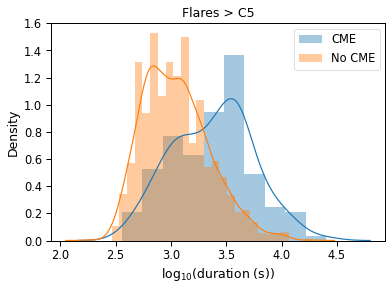

In [301]:
sns.distplot(np.log10(flare_cmes["full_dur"]), label="CME")
sns.distplot(np.log10(flare_nocmes["full_dur"]),  label="No CME")
plt.xlabel("log$_{10}$(duration (s))")
plt.legend()
plt.title("Flares > C5")
# plt.savefig("flare_duration_cmes.png", dpi=200, facecolor="w")

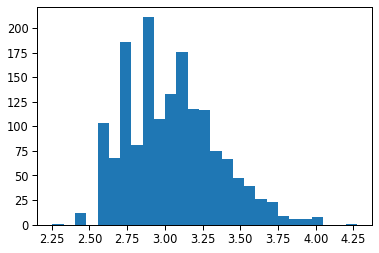

In [302]:
_ = hist(np.log10(flare_nocmes["full_dur"]), bins="knuth")
